<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/GENTIEU_Martin_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin et GOUESSE Sixtine : TP2 de data analytics


## Préparation des données utiles pour le TP2 :

###On se place dans un premier temps dans le répertoire parent

In [1]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]/"TP2"
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages/TP2
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime

On exécute ensuite le script python test.py pour récupérer les messages (environ 700 000).
Si un fichier CSV commençant par **"data_TP2_"** existe, alors on n'exécute pas le code de récupération des messages.

In [3]:
HOST = "sbs.glidernet.org"
PORT = 30003

cols = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

# Cherche un fichier existant data_TP2_*.csv
existing_files = glob.glob(f"{PROJECT_ROOT}/adsb_data_*.csv")

if existing_files:
    # Si plusieurs → on prend le plus récent
    output_file = max(existing_files, key=os.path.getmtime)
    print(f"Fichier existant trouvé : {output_file}")
else:
    # Sinon on en crée un nouveau
    date = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"{PROJECT_ROOT}/adsb_data_{date}.csv"
    print(f"Aucun fichier existant. Nouveau fichier : {output_file}")


    print(f"Connexion à {HOST}:{PORT} ...")

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        print("Connecté ! Réception des messages ADS-B...\n")

        # Teste si le fichier existe déjà (on ne réécrit pas le header)
        file_exists = os.path.isfile(output_file) and os.path.getsize(output_file) > 0

        with open(output_file, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f, delimiter=",")

            # Écrit le header seulement si le fichier est nouveau/vide
            if not file_exists:
                writer.writerow(cols)

            try:
                for i in range(25000):
                    data = s.recv(1024).decode(errors="ignore")

                    for line in data.strip().split("\n"):
                        if line.startswith("MSG"):
                            fields = line.split(",")

                            # Complète si trop court
                            if len(fields) < len(cols):
                                fields += [""] * (len(cols) - len(fields))

                            writer.writerow(fields)

                    if i % 5000 == 0:
                        print(f"{i} itérations traitées")

            except KeyboardInterrupt:
                print("\nArrêt manuel par l’utilisateur.")
            except Exception as e:
                print("Erreur :", e)

    print(f"\nDonnées enregistrées dans : {output_file}")


Fichier existant trouvé : /content/Data_analytics_aircraft_messages/TP2/adsb_data_20251120_091555.csv


###Récupération des données utiles pour un avion (en utilisant l'identifiant ICAO)

In [4]:
df = pd.read_csv(output_file)
split_df = df["Message"].str.split(",", expand=True)

# Nommer les colonnes SBS-1
colnames = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

split_df.columns = colnames[:split_df.shape[1]]

df=split_df.copy()

Analyse initiale du dataset :

In [5]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3,,,A2A3B6,,2025/11/20,08:15:55.243,2025/11/20,08:15:55.243,...,202.0,250.0,50.11797,8.83735,,,0,0,0,0
1,MSG,3,,,043EA0,,2025/11/20,08:15:55.245,2025/11/20,08:15:55.245,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
2,MSG,3,,,45AC4F,,2025/11/20,08:15:55.246,2025/11/20,08:15:55.246,...,330.0,212.0,51.56957,4.85748,,,0,0,0,0
3,MSG,3,,,440C9B,,2025/11/20,08:15:55.248,2025/11/20,08:15:55.248,...,334.0,109.0,49.13595,10.37468,,,0,0,0,0
4,MSG,3,,,4ACA73,,2025/11/20,08:15:55.249,2025/11/20,08:15:55.249,...,142.0,16.0,60.23327,11.10172,,,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549068 entries, 0 to 549067
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   MessageType       549068 non-null  object
 1   TransmissionType  549063 non-null  object
 2   SessionID         549045 non-null  object
 3   AircraftID        549031 non-null  object
 4   HexIdent          549011 non-null  object
 5   FlightID          548904 non-null  object
 6   DateGenerated     548889 non-null  object
 7   TimeGenerated     548739 non-null  object
 8   DateLogged        546124 non-null  object
 9   TimeLogged        530150 non-null  object
 10  Callsign          518004 non-null  object
 11  Altitude          516259 non-null  object
 12  GroundSpeed       510525 non-null  object
 13  Track             497907 non-null  object
 14  Latitude          487700 non-null  object
 15  Longitude         482444 non-null  object
 16  VerticalRate      481943 non-null  obj

In [7]:
df.describe()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,549068,549063,549045,549031,549011,548904,548889,548739,546124,530150,...,510525,497907,487700,482444,481943,481927,481916,481897,481875,481862
unique,1,2,1,1,1878,1,11,546995,11,519066,...,1504,1058,310228,344745,1,1,2,2,2,2
top,MSG,3,,,043EA0,,2025/11/20,08:,2025/11/20,,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
freq,549068,549055,549045,549031,5205,548904,548750,35,531844,1629,...,18858,14883,4623,4594,481943,481927,481908,481886,481866,481857


###1.2. Extraction des colonnes utiles

In [8]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp' : df["DateGenerated"] + " " + df["TimeGenerated"]
})

df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')

df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,515709.000000,508653.000000,495698.000000,486502.000000,482278.000000,548066
mean,12282.937420,262.242405,170.490472,47.199046,6.570437,2025-11-20 08:29:15.928083200
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:15:55.243000
25%,4588.000000,183.000000,90.000000,45.212330,2.079128,2025-11-20 08:22:45.350499840
50%,10375.000000,278.000000,164.000000,50.000000,7.772665,2025-11-20 08:29:20.871000064
75%,15928.000000,346.000000,258.000000,51.661180,10.790695,2025-11-20 08:35:46.928499968
max,215033.000000,729.000000,360.000000,70.339620,175.736980,2025-11-20 08:42:17.264000
std,10063.390551,122.118410,103.321355,12.440266,11.267934,NaN


In [9]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549068 entries, 0 to 549067
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   icao          549011 non-null  object        
 1   registration  518004 non-null  object        
 2   altitude      515709 non-null  float64       
 3   velocity      508653 non-null  float64       
 4   heading       495698 non-null  float64       
 5   lat           486502 non-null  float64       
 6   lon           482278 non-null  float64       
 7   timestamp     548066 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 33.5+ MB


In [10]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
0,A2A3B6,ICAA2A3B6,4819.0,202.0,250.0,50.11797,8.83735,2025-11-20 08:15:55.243
1,043EA0,FLR043EA0,820.0,0.0,0.0,50.00000,20.00000,2025-11-20 08:15:55.245
2,45AC4F,OY-KBO,15651.0,330.0,212.0,51.56957,4.85748,2025-11-20 08:15:55.246
3,440C9B,OE-LFQ,14471.0,334.0,109.0,49.13595,10.37468,2025-11-20 08:15:55.248
4,4ACA73,ICA4ACA73,2677.0,142.0,16.0,60.23327,11.10172,2025-11-20 08:15:55.249


## On sélectionne maintenant un avion en particulier

On trie ensuite par timestamp pour obtenir les messages triés en fonction du temps (du plus vieux au plus récent)

In [11]:
# On teste pour plusieurs avions au cas où on observe des erreurs.
icao_sample = df_parsed['icao'].value_counts().index[0]
icao_sample2 = df_parsed['icao'].value_counts().index[1]
icao_sample3 = df_parsed['icao'].value_counts().index[2]
icao_sample4 = df_parsed['icao'].value_counts().index[3]
icao_sample5 = df_parsed['icao'].value_counts().index[4]
icao_sample6 = df_parsed['icao'].value_counts().index[5]
icao_sample7 = df_parsed['icao'].value_counts().index[6]
icao_sample8 = df_parsed['icao'].value_counts().index[7]
icao_sample9 = df_parsed['icao'].value_counts().index[8]
icao_sample10 = df_parsed['icao'].value_counts().index[9]
print(icao_sample)
print(icao_sample2)
print(icao_sample3)
print(icao_sample4)
print(icao_sample5)
flight = df_parsed[df_parsed['icao'] == icao_sample2].sort_values('timestamp')
flight.info()

043EA0
4D2537
E80421
4CA295
4D251B
<class 'pandas.core.frame.DataFrame'>
Index: 4266 entries, 821 to 395733
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          4266 non-null   object        
 1   registration  4047 non-null   object        
 2   altitude      4025 non-null   float64       
 3   velocity      3958 non-null   float64       
 4   heading       3855 non-null   float64       
 5   lat           3784 non-null   float64       
 6   lon           3767 non-null   float64       
 7   timestamp     4258 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 300.0+ KB


On tâche de nettoyer un peu le dataset sur les valeurs manquantes

In [12]:
flight.dropna(inplace=True)
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3767 entries, 821 to 549037
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          3767 non-null   object        
 1   registration  3767 non-null   object        
 2   altitude      3767 non-null   float64       
 3   velocity      3767 non-null   float64       
 4   heading       3767 non-null   float64       
 5   lat           3767 non-null   float64       
 6   lon           3767 non-null   float64       
 7   timestamp     3767 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 264.9+ KB


In [13]:
flight.head(15)

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
821,4D2537,ICA4D2537,8120.0,176.0,209.0,51.19822,6.24972,2025-11-20 08:15:57.809
895,4D2537,ICA4D2537,8152.0,176.0,209.0,51.19755,6.24912,2025-11-20 08:15:58.056
1325,4D2537,ICA4D2537,8188.0,176.0,209.0,51.19682,6.24847,2025-11-20 08:15:59.411
1340,4D2537,ICA4D2537,8191.0,176.0,209.0,51.19682,6.24848,2025-11-20 08:15:59.461
1538,4D2537,ICA4D2537,8222.0,176.0,209.0,51.19610,6.24783,2025-11-20 08:16:00.041
1815,4D2537,ICA4D2537,8260.0,176.0,209.0,51.19540,6.24723,2025-11-20 08:16:00.949
2138,4D2537,ICA4D2537,8277.0,175.0,209.0,51.19465,6.24652,2025-11-20 08:16:02.054
2245,4D2537,ICA4D2537,8299.0,175.0,209.0,51.19467,6.24655,2025-11-20 08:16:02.372
2331,4D2537,ICA4D2537,8310.0,175.0,209.0,51.19398,6.24595,2025-11-20 08:16:02.681
2352,4D2537,ICA4D2537,8312.0,175.0,209.0,51.19400,6.24598,2025-11-20 08:16:02.762


1.a Extraction des variables dynamiques

**Calcul de l'accélération instantanée**

On calcule l'accélération entre deux instances de messages collectés.



In [14]:
def calculate_acceleration(velocity_1, velocity_2, timestamp_1, timestamp_2):
    if pd.isnull(velocity_1) or pd.isnull(velocity_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (velocity_2 - velocity_1) / (timestamp_2 - timestamp_1).total_seconds()

# On shift de 50 pour avoir des données suffisamment espacées dans le temps
flight['prev_velocity']=flight['velocity'].shift(50)
flight['prev_timestamp']=flight['timestamp'].shift(50)
flight['acceleration'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_velocity'], row['velocity'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_velocity']) else None,
    axis=1
)

**On calcule à présent la variation de cap (Heading)**

Cette fois, on calcule la variation de cap entre deux instances de messages collectés

In [15]:
def calculate_heading_variation(heading_1, heading_2, timestamp_1, timestamp_2):
    if pd.isnull(heading_1) or pd.isnull(heading_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (heading_2 - heading_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_heading']=flight['heading'].shift(50)
flight['heading_var'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_heading'], row['heading'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_heading']) else None,
    axis=1
)

**On calcule à présent la vitesse verticale (en ft par minutes)**

Pour cela, on calcule la différence d'altitude entre deux lignes et on normalise pour une différence entre des intervalles de 60 secondes

In [16]:
def calculate_vertical_speed(altitude_1, altitude_2, timestamp_1, timestamp_2):
    if pd.isnull(altitude_1) or pd.isnull(altitude_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return 60.0 * (altitude_2 - altitude_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_altitude']=flight['altitude'].shift(50)
flight['vertical_speed'] = flight.apply(
    lambda row: calculate_vertical_speed(
        row['prev_altitude'], row['altitude'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_altitude']) else None,
    axis=1
)

In [17]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3767 entries, 821 to 549037
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            3767 non-null   object        
 1   registration    3767 non-null   object        
 2   altitude        3767 non-null   float64       
 3   velocity        3767 non-null   float64       
 4   heading         3767 non-null   float64       
 5   lat             3767 non-null   float64       
 6   lon             3767 non-null   float64       
 7   timestamp       3767 non-null   datetime64[ns]
 8   prev_velocity   3717 non-null   float64       
 9   prev_timestamp  3717 non-null   datetime64[ns]
 10  acceleration    3717 non-null   float64       
 11  prev_heading    3717 non-null   float64       
 12  heading_var     3717 non-null   float64       
 13  prev_altitude   3717 non-null   float64       
 14  vertical_speed  3717 non-null   float64       
dtypes: da

## On calcule enfin la distance parcourue avec la méthode Haversine

In [18]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371000.0  # Rayon de la Terre en mètres

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

first_lat = flight['lat'].iloc[0]
first_lon = flight['lon'].iloc[0]
flight['distance'] = haversine_vectorized(first_lat, first_lon, flight['lat'], flight['lon'])

In [19]:
flight.dropna(inplace=True)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,prev_velocity,prev_timestamp,acceleration,prev_heading,heading_var,prev_altitude,vertical_speed,distance
12412,4D2537,ICA4D2537,9310.0,173.0,209.0,51.17157,6.22612,2025-11-20 08:16:35.254,176.0,2025-11-20 08:15:57.809,-0.080118,209.0,0.0,8120.0,1906.796635,3389.250544
13317,4D2537,ICA4D2537,9415.0,172.0,209.0,51.16943,6.22427,2025-11-20 08:16:37.704,176.0,2025-11-20 08:15:58.056,-0.100888,209.0,0.0,8152.0,1911.319613,3659.903960
13952,4D2537,ICA4D2537,9483.0,172.0,209.0,51.16807,6.22302,2025-11-20 08:16:39.910,176.0,2025-11-20 08:15:59.411,-0.098768,209.0,0.0,8188.0,1918.565891,3834.421193
13971,4D2537,ICA4D2537,9477.0,172.0,209.0,51.16807,6.22300,2025-11-20 08:16:39.960,176.0,2025-11-20 08:15:59.461,-0.098768,209.0,0.0,8191.0,1905.232228,3835.097960
14498,4D2537,ICA4D2537,9517.0,172.0,209.0,51.16740,6.22242,2025-11-20 08:16:41.498,176.0,2025-11-20 08:16:00.041,-0.096486,209.0,0.0,8222.0,1874.231131,3919.862809


In [20]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3717 entries, 12412 to 549037
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            3717 non-null   object        
 1   registration    3717 non-null   object        
 2   altitude        3717 non-null   float64       
 3   velocity        3717 non-null   float64       
 4   heading         3717 non-null   float64       
 5   lat             3717 non-null   float64       
 6   lon             3717 non-null   float64       
 7   timestamp       3717 non-null   datetime64[ns]
 8   prev_velocity   3717 non-null   float64       
 9   prev_timestamp  3717 non-null   datetime64[ns]
 10  acceleration    3717 non-null   float64       
 11  prev_heading    3717 non-null   float64       
 12  heading_var     3717 non-null   float64       
 13  prev_altitude   3717 non-null   float64       
 14  vertical_speed  3717 non-null   float64       
 15  dis

In [21]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp,prev_velocity,prev_timestamp,acceleration,prev_heading,heading_var,prev_altitude,vertical_speed,distance
count,3717.000000,3717.000000,3717.000000,3717.000000,3717.000000,3717,3717.000000,3717,3717.000000,3717.000000,3717.000000,3717.000000,3717.000000,3717.000000
mean,22534.314501,229.715631,225.497175,50.612659,5.353261,2025-11-20 08:30:06.699837440,228.574926,2025-11-20 08:29:45.829064960,0.063152,225.268496,0.006820,22307.278988,561.659030,90620.467543
min,9310.000000,0.000000,0.000000,50.039150,4.422870,2025-11-20 08:16:35.254000,0.000000,2025-11-20 08:15:57.809000,-15.906681,0.000000,-17.118618,8120.000000,-5991.136180,3389.250544
25%,20455.000000,210.000000,226.000000,50.378830,4.967700,2025-11-20 08:24:42.694000128,209.000000,2025-11-20 08:24:23.964999936,0.000000,226.000000,0.000000,20099.000000,0.000000,51531.197622
50%,25521.000000,224.000000,226.000000,50.612980,5.350280,2025-11-20 08:30:35.856000,223.000000,2025-11-20 08:30:21.188999936,0.043745,226.000000,0.000000,25506.000000,111.684881,90621.290888
75%,25552.000000,258.000000,227.000000,50.855750,5.753300,2025-11-20 08:35:32.048000,258.000000,2025-11-20 08:35:14.292000,0.123449,227.000000,0.000000,25552.000000,1039.252336,128148.890527
max,27011.000000,262.000000,227.000000,51.171570,6.226120,2025-11-20 08:42:17.195000,262.000000,2025-11-20 08:41:55.128000,14.504432,227.000000,15.175933,27011.000000,7635.206787,182257.515137
std,4401.895229,26.848007,5.170277,0.299263,0.490184,NaN,27.376311,NaN,0.377609,5.507995,0.380350,4666.712213,624.174763,47905.485983


###On sélectionne maintenant uniquement les colonnes qui nous intéresse :

In [22]:
flight = flight.drop(columns=[col for col in flight.columns if col.startswith("prev_")])
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3717 entries, 12412 to 549037
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            3717 non-null   object        
 1   registration    3717 non-null   object        
 2   altitude        3717 non-null   float64       
 3   velocity        3717 non-null   float64       
 4   heading         3717 non-null   float64       
 5   lat             3717 non-null   float64       
 6   lon             3717 non-null   float64       
 7   timestamp       3717 non-null   datetime64[ns]
 8   acceleration    3717 non-null   float64       
 9   heading_var     3717 non-null   float64       
 10  vertical_speed  3717 non-null   float64       
 11  distance        3717 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 377.5+ KB


#1. b : Horodotage

On convertit les champs *date* et *heure* en format normalisé timestamp car cela nous permet d'effectuer des opérations cohérentes avec les secondes, microsecondes, etc.

Cela est particulièrement utile lorsqu'on réalise nos calculs pour trouver les variables dynamiques, telles que la vitesse ou l'accélération.

#1.c Construction du label

On construit à présent la variable cible : *altitude_future_t+10s* qui montre l'altitude réelle à t+10s en fonction des données comprises dans notre dataset.

Si nous n'avons pas de données explicitant l'altitude dans 10 secondes (donc si on est vers la fin du dataset), on extrapole en utilisant les informations suivantes :
- la vitesse actuelle
- le vitesse de la dernière valeur enregistrée

In [23]:
def compute_altitude_future(df, delta_s=10):
    """
    Crée la variable cible 'altitude_future_t_10s'.
    Interpolation linéaire si un saut entre les mesures existe.
    Extrapolation si on est vers la fin du dataset.
    """
    # Tri chronologique
    df = df.sort_values("timestamp").reset_index(drop=True)

    future_alt = []

    timestamps = df["timestamp"].values
    altitudes = df["altitude"].values
    velocities = df["velocity"].values
    n = len(df)

    for i in range(n):
        t_now = timestamps[i]
        alt_now = altitudes[i]
        target_time = t_now + np.timedelta64(delta_s, "s")

        # Cherche le prochain indice >= t_now + delta_s
        j = i
        while j < n and timestamps[j] < target_time:
            j += 1

        if j < n: #On a dépassé t+10s. On faire une interpollation entre j et j-1 ensuite.
                  #Car on a en effet j = valeur juste après | j-1 = valeur juste avant.
            if j > 0:
                t1 = timestamps[j-1]
                t2 = timestamps[j]
                alt1 = altitudes[j-1]
                alt2 = altitudes[j]

                # fraction de temps entre t_now et t2
                frac = (target_time - t1) / (t2 - t1)
                alt_future = alt1 + frac * (alt2 - alt1)
            else:
                # Cas j=0, pas de j-1 → on prend simplement altitudes[j]
                alt_future = altitudes[j]

            future_alt.append(alt_future)

        else:
            # ---- Extrapolation linéaire avec vitesse ----
            v_current = velocities[i]
            v_last = velocities[-1]
            v_mean = (v_current + v_last) / 2
            alt_future = alt_now + v_mean * delta_s
            future_alt.append(alt_future)

    df["altitude_future_t+10s"] = future_alt
    return df

flight = compute_altitude_future(flight)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,acceleration,heading_var,vertical_speed,distance,altitude_future_t+10s
0,4D2537,ICA4D2537,9310.0,173.0,209.0,51.17157,6.22612,2025-11-20 08:16:35.254,-0.080118,0.0,1906.796635,3389.250544,9611.850123
1,4D2537,ICA4D2537,9415.0,172.0,209.0,51.16943,6.22427,2025-11-20 08:16:37.704,-0.100888,0.0,1911.319613,3659.903960,9680.886567
2,4D2537,ICA4D2537,9483.0,172.0,209.0,51.16807,6.22302,2025-11-20 08:16:39.910,-0.098768,0.0,1918.565891,3834.421193,9763.984526
3,4D2537,ICA4D2537,9477.0,172.0,209.0,51.16807,6.22300,2025-11-20 08:16:39.960,-0.098768,0.0,1905.232228,3835.097960,9765.241779
4,4D2537,ICA4D2537,9517.0,172.0,209.0,51.16740,6.22242,2025-11-20 08:16:41.498,-0.096486,0.0,1874.231131,3919.862809,9824.757094


In [24]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp,acceleration,heading_var,vertical_speed,distance,altitude_future_t+10s
count,3717.000000,3717.000000,3717.000000,3717.000000,3717.000000,3717,3717.000000,3717.000000,3717.000000,3717.000000,3717.000000
mean,22534.314501,229.715631,225.497175,50.612659,5.353261,2025-11-20 08:30:06.699837440,0.063152,0.006820,561.659030,90620.467543,22641.398183
min,9310.000000,0.000000,0.000000,50.039150,4.422870,2025-11-20 08:16:35.254000,-15.906681,-17.118618,-5991.136180,3389.250544,9611.850123
25%,20455.000000,210.000000,226.000000,50.378830,4.967700,2025-11-20 08:24:42.694000128,0.000000,0.000000,0.000000,51531.197622,20632.169102
50%,25521.000000,224.000000,226.000000,50.612980,5.350280,2025-11-20 08:30:35.856000,0.043745,0.000000,111.684881,90621.290888,25523.223250
75%,25552.000000,258.000000,227.000000,50.855750,5.753300,2025-11-20 08:35:32.048000,0.123449,0.000000,1039.252336,128148.890527,25550.617713
max,27011.000000,262.000000,227.000000,51.171570,6.226120,2025-11-20 08:42:17.195000,14.504432,15.175933,7635.206787,182257.515137,28171.000000
std,4401.895229,26.848007,5.170277,0.299263,0.490184,NaN,0.377609,0.380350,624.174763,47905.485983,4332.244435


#2. Modélisation supervisée

##2.a Régression linéaire

On entraîne un modèle de régression linéaire pour prédire l'altitude à t+10 secondes

In [25]:
# Colonnes utilisées pour prédire l'altitude future
exclude_cols = ["icao", "registration", "altitude_future_t+10s", "timestamp"]
features = [col for col in flight.columns if col not in exclude_cols]

X = flight[features]
y = flight["altitude_future_t+10s"]

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Initialisation
model = LinearRegression()

# Entraînement
model.fit(X_train, y_train)


LinearRegression()

In [27]:
# Prédiction
y_pred_linear = model.predict(X_test)

In [28]:
for feat, coef in zip(features, model.coef_):
    print(f"{feat}: {coef:.3f}")

print("Intercept:", model.intercept_)


altitude: 1.006
velocity: -1.959
heading: 6.914
lat: 30397.779
lon: 17611.094
acceleration: 127.956
heading_var: -11.096
vertical_speed: 0.208
distance: 0.372
Intercept: -1667735.1345114035


# 2.b Random Forest

In [29]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Entraînement
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# 2.c Comparaison numérique des performances

In [30]:
def eval_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"=== {name} ===")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE  : {mae:.2f}")
    print(f"R²   : {r2:.4f}")
    print()

In [31]:
eval_model(y_test, y_pred_linear, "Modèle 2 (Linear Regression)")
eval_model(y_test, y_pred_rf, "Modèle 1 (Random Forest)")

=== Modèle 2 (Linear Regression) ===
RMSE : 240.64
MAE  : 65.26
R²   : 0.9972

=== Modèle 1 (Random Forest) ===
RMSE : 80.11
MAE  : 9.28
R²   : 0.9997



# 3. Visualisation et analyse graphique des performances

### Performances de la régression linéaire :

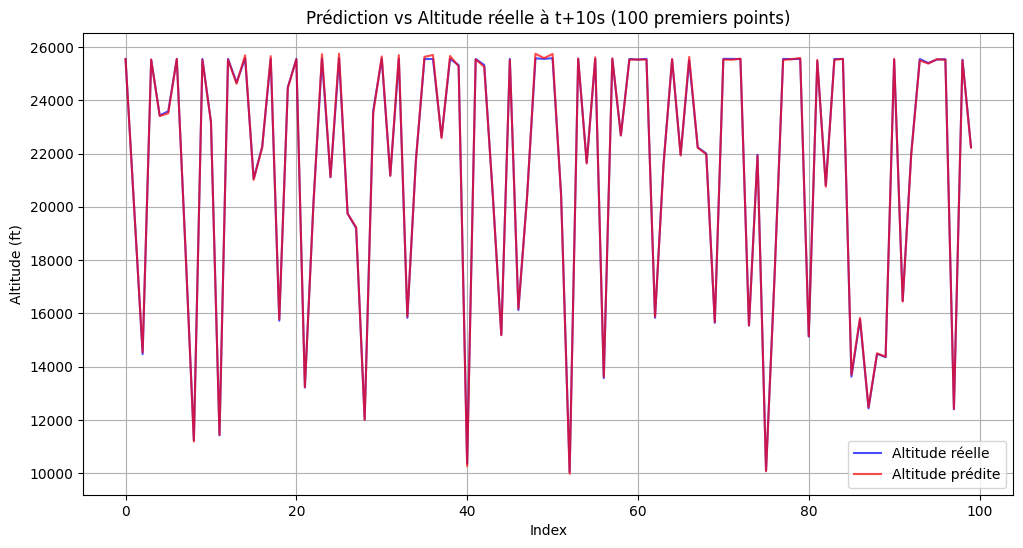

In [32]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Altitude réelle", color="blue", alpha=0.7)
plt.plot(y_pred_linear[:100], label="Altitude prédite", color="red",alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Altitude (ft)")
plt.title("Prédiction vs Altitude réelle à t+10s (100 premiers points)")
plt.legend()
plt.grid(True)
plt.show()

### Performances du Random Forest

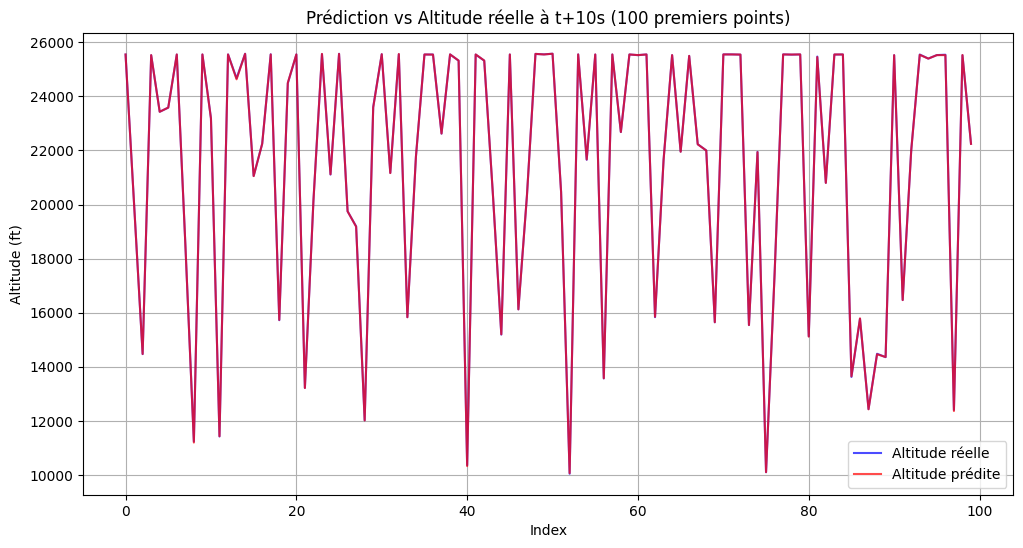

In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Altitude réelle", color="blue", alpha=0.7)
plt.plot(y_pred_rf[:100], label="Altitude prédite", color="red",alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Altitude (ft)")
plt.title("Prédiction vs Altitude réelle à t+10s (100 premiers points)")
plt.legend()
plt.grid(True)
plt.show()

### Analyse visuelle des résidus :

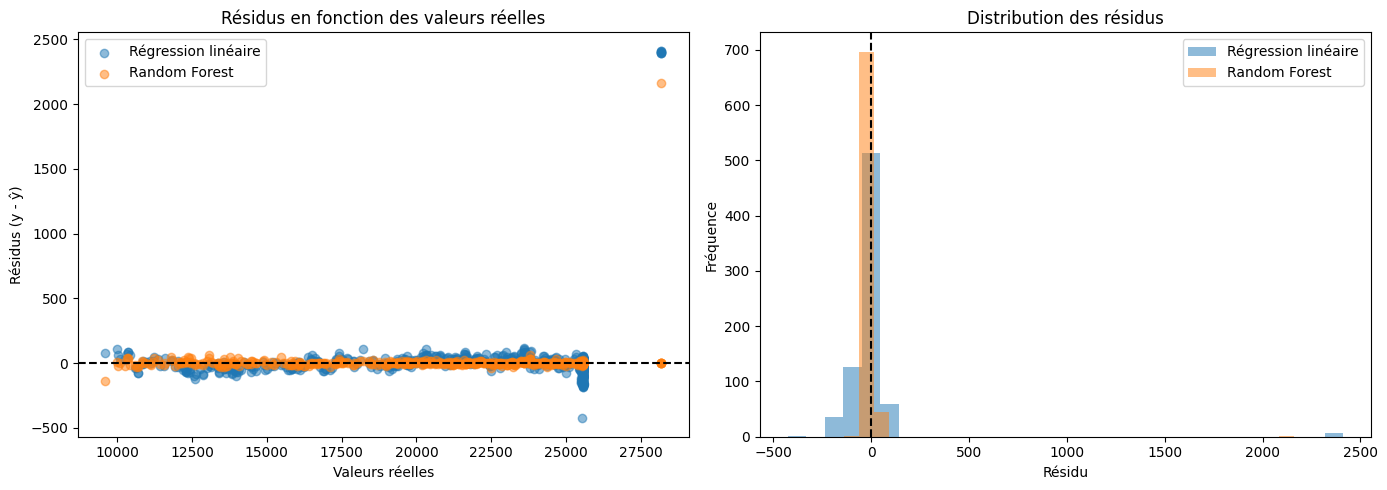

In [34]:
res_linear = y_test - y_pred_linear
res_rf = y_test - y_pred_rf

plt.figure(figsize=(14,5))

# Scatter résidus
plt.subplot(1,2,1)
plt.scatter(y_test, res_linear, alpha=0.5, label="Régression linéaire")
plt.scatter(y_test, res_rf, alpha=0.5, label="Random Forest")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus (y - ŷ)")
plt.title("Résidus en fonction des valeurs réelles")
plt.legend()

# Histogramme des résidus
plt.subplot(1,2,2)
plt.hist(res_linear, bins=30, alpha=0.5, label="Régression linéaire")
plt.hist(res_rf, bins=30, alpha=0.5, label="Random Forest")
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribution des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.legend()

plt.tight_layout()
plt.show()